<a href="https://colab.research.google.com/github/SerafinCarba/Ejercicio-de-programaci-n-de-combinaciones-de-funciones/blob/master/feature_crosses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Combinaciones de atributos

 **Objetivos de aprendizaje:**
  * mejorar un modelo de regresión lineal con la incorporación de atributos sintéticos adicionales (esto es una continuación del ejercicio anterior)
  * usar una función de entrada para convertir los objetos `DataFrame` de Pandas en `Tensors` e invocar la función de entrada en las operaciones `fit()` y `predict()`
  * usar el algoritmo de optimización de FTRL para el entrenamiento del modelo
  * crear atributos sintéticos nuevos mediante codificación de un solo 1, discretización y combinaciones de atributos

 ## Preparación

 Primero, como lo hicimos en ejercicios anteriores, definamos la entrada y creemos el código para cargar los datos.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2639.5,538.3,1429.0,500.5,3.9,2.0
std,2.1,2.0,12.5,2176.9,418.0,1140.6,380.6,1.9,1.0
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1456.8,298.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.5,435.0,1170.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3156.0,647.0,1715.0,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,41.3


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2653.7,542.0,1431.0,503.1,3.9,2.0
std,2.1,2.0,12.7,2187.4,429.8,1165.2,393.7,1.9,1.5
min,32.5,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1474.0,294.0,783.0,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2131.0,430.0,1159.0,404.0,3.6,2.0
75%,37.7,-118.0,37.0,3138.8,653.0,1742.8,609.0,4.7,2.3
max,41.9,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.0
std,115.9
min,15.0
25%,118.9
50%,181.1
75%,263.6
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.0
std,116.3
min,15.0
25%,121.0
50%,179.1
75%,268.7
max,500.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 ## Algoritmo de optimización FTRL

Los modelos lineales de dimensiones altas se benefician del uso de una variante de optimización basada en gradientes, que se denomina FTRL. Este algoritmo tiene la ventaja de ajustar la tasa de aprendizaje de distintas maneras para diferentes coeficientes, lo cual puede resultar útil si algunos atributos raramente toman valores distintos de cero (también es adecuado cuando se utiliza regularización L1). Podemos aplicar FTRL a través de la función [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 255.08
  period 01 : 154.06
  period 02 : 141.73
  period 03 : 116.74
  period 04 : 163.62
  period 05 : 115.83
  period 06 : 121.24
  period 07 : 116.85
  period 08 : 319.64
  period 09 : 139.87
Model training finished.


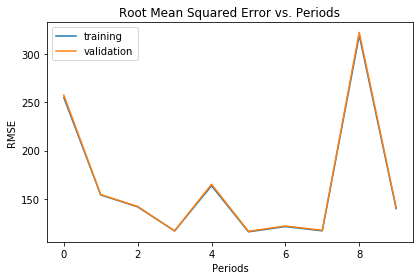

In [8]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Codificación de un solo 1 para atributos discretos

Los atributos discretos (es decir, strings, enumeraciones, enteros) generalmente se convierten en familias de atributos binarios antes de entrenar un modelo de regresión logística.

Por ejemplo, imagina que creamos un atributo sintético que puede tomar cualquiera de los valores `0`, `1` o `2`, y que tenemos algunos puntos de entrenamiento:

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

Para cada valor categórico posible, generamos un nuevo atributo **binario** de **valores reales** que puede tomar uno de solo dos valores posibles: 1.0 si el ejemplo tiene ese valor y 0.0 si no lo tiene. En el ejemplo anterior, el atributo categórico se convertiría en tres atributos y los puntos de entrenamiento tendrían el siguiente aspecto:

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

 ## Atributos agrupados (discretizados)

El agrupamiento también se conoce como discretización.

Podemos agrupar `population` en los siguientes 3 agrupamientos (a modo de ejemplo):
- `bucket_0` (`< 5000`): Corresponde a las manzanas menos pobladas.
- `bucket_1` (`5000 - 25000`): Corresponde a las manzanas con un nivel de población medio.
- `bucket_2` (`> 25000`): Corresponde a las manzanas altamente pobladas.

Dadas las definiciones de agrupamiento anteriores, el siguiente vector `population`:

    [[10001], [42004], [2500], [18000]]

se convierte en el siguiente vector de atributos agrupados:

    [[1], [2], [0], [1]]

Los valores de los atributos ahora son los índices de agrupamiento. Ten en cuenta que estos índices se consideran atributos discretos. Por lo general, estos se convertirán posteriormente en representaciones de un solo 1 como se mostró más arriba, pero esto se realizará de manera transparente.

Para definir columnas de atributos para los atributos agrupados, en lugar de usar `numeric_column`, podemos usar [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column), que toma una columna numérica como entrada y la transforma en un atributo  agrupado a través de los límites de agrupamiento que se especifican en el argumento `boundaries`. El siguiente código define columnas de atributos agrupados para `households` y `longitude`. La función `get_quantile_based_boundaries` calcula los límites en función de los cuantiles, de manera que cada agrupamiento contiene el mismo número de elementos.

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
  households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
  longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

 ## Tarea 1: Entrena el modelo con columnas de atributos agrupados
**Agrupa todos los atributos con valores reales de nuestro ejemplo, entrena el modelo y observa si mejoran los resultados.**

En el bloque de código anterior, se transformaron dos columnas con valores reales (concretamente `households` y `longitude`) en columnas de atributos agrupados. Tu tarea es agrupar el resto de las columnas y, luego, ejecutar el código para entrenar el modelo. Hay distintas heurísticas para buscar el rango de los agrupamientos. En este ejercicio se usa una técnica basada en cuantiles, que elige los límites de los agrupamientos de manera tal que cada agrupamiento tenga el mismo número de ejemplos.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))

  #
  # YOUR CODE HERE: bucketize the following columns, following the example above:
  #
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))
  
  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
      housing_median_age,boundaries=get_quantile_based_boundaries(
          training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
     median_income,boundaries=get_quantile_based_boundaries(
         training_examples['median_income'], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
      rooms_per_person,boundaries=get_quantile_based_boundaries(
          training_examples['rooms_per_person'], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 169.24
  period 01 : 142.98
  period 02 : 126.58
  period 03 : 115.49
  period 04 : 107.63
  period 05 : 101.85
  period 06 : 97.44
  period 07 : 93.93
  period 08 : 91.08
  period 09 : 88.69
Model training finished.


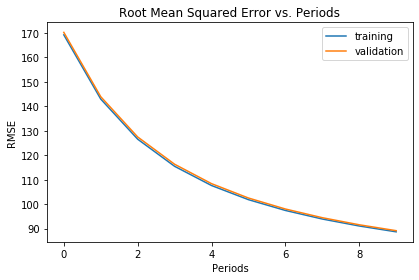

In [19]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solución

Haz clic más abajo para conocer la solución.

 Posiblemente te preguntes cómo determinar cuántos agrupamientos debes usar. Eso, desde luego, depende de los datos. Aquí, simplemente seleccionamos valores arbitrarios como para obtener un modelo que no fuera demasiado grande.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 169.33
  period 01 : 143.13
  period 02 : 126.67
  period 03 : 115.58
  period 04 : 107.73
  period 05 : 101.91
  period 06 : 97.52
  period 07 : 94.02
  period 08 : 91.15
  period 09 : 88.73
Model training finished.


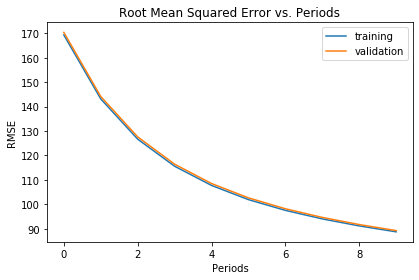

In [16]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Combinaciones de funciones

Combinar dos (o más) atributos es una forma inteligente de aprender relaciones no lineales a través de un modelo lineal. En nuestro problema, si simplemente usamos el atributo `latitude` para el aprendizaje, el modelo podría aprender que las manzanas de una latitud en particular (o dentro de un rango específico de latitudes, dado que la agrupamos) tienen más probabilidades de ser más costosas que otras. Algo similar ocurre para el atributo `longitude`. Sin embargo, si combinamos `longitude` con `latitude`, el atributo combinado representa una manzana bien definida. Si el modelo aprende que determinadas manzanas (dentro de un rango de latitudes y longitudes) tienen más probabilidades de ser más costosas que otras, es un indicador más claro que dos atributos considerados de forma individual.

Actualmente, la API de columnas de atributos solo admite atributos discretos para las combinaciones. Para combinar dos valores continuos, como `latitude` o `longitude`, podemos agruparlos.

Si combinamos los atributos `latitude` y `longitude` (suponiendo, por ejemplo, que `longitude` se agrupó en `2` agrupamientos, mientras que `latitude` tiene `3` agrupamientos), obtenemos seis atributos binarios combinados. Cada uno de esos atributos obtendrá su propia ponderación por separado cuando se entrene el modelo.

 ## Tarea 2: Entrena el modelo con combinaciones de atributos

**Agrega una combinación de atributos de `longitude` y `latitude` a tu modelo, entrénalo y determina si mejoran los resultados.**

Consulta la documentación de la API de TensorFlow para obtener información sobre [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) a fin de crear la columna de atributos para tu combinación. Usa un `hash_bucket_size` de `1000`.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
      set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
  
  # Feature column for housing_median_age x median_income featrue cross
  housing_median_age_x_median_income = tf.feature_column.crossed_column(
      set([bucketized_housing_median_age,bucketized_median_income]), hash_bucket_size=1000)
  
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat,
    housing_median_age_x_median_income])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 158.00
  period 01 : 128.24
  period 02 : 111.09
  period 03 : 99.91
  period 04 : 92.41
  period 05 : 86.90
  period 06 : 82.83
  period 07 : 79.65
  period 08 : 77.16
  period 09 : 75.05
Model training finished.


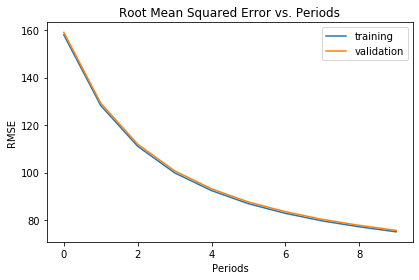

In [25]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solución

Haz clic más abajo para conocer la solución.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

In [0]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Desafío opcional: Prueba más atributos sintéticos

Hasta el momento, hemos probado combinaciones de atributos y columnas agrupadas simples, pero hay muchas más combinaciones que posiblemente podrían mejorar los resultados. Por ejemplo, podrías combinar varias columnas. ¿Qué ocurre si varías la cantidad de agrupamientos? ¿En qué otras atributos sintéticos puedes pensar? ¿Mejoran el modelo?